In [1]:
from sympy import Symbol, symbols, Matrix, sin, cos, Eq, init_printing
import numpy as np
from IPython.display import display

init_printing()

vs, psis, dpsis, dts, xs, ys, lats, lons, axs = symbols('v \psi \dot\psi T x y lat lon a')

hs = Matrix([[xs],
             [ys],
             [psis],
             [vs],
             [dpsis],
             [axs]])

state = Matrix([xs,ys,psis,vs,dpsis,axs])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]

In [2]:
import numpy as np


STATE_SIZE = 6 # States
STATE_X_IDX, STATE_Y_IDX, STATE_YAW_IDX, STATE_VELOCITY_IDX, STATE_YAW_RATE_IDX, STATE_ACCELERATION_IDX = range(STATE_SIZE)

# Generated running the loop with correction commented, just with prediction
mock = np.array([
    # Generated with x = [10, 10, np.pi/2, 5, np.pi/10, 5]
    [9.99162312, 10.52491159, 1.60221225, 5.5, 0.31415927, 5.],
    [9.96440727, 11.09924348, 1.63362818, 6. , 0.31415927, 5.],
    [9.91524186, 11.72228092, 1.66504411, 6.5, 0.31415927, 5.],

    # Generated with x = [9.84104414, 12.39316261, 1.69646003, 7 , 0, 2]
    [9.84104414, 12.39316261, 1.69646003, 7 , 0, 2],
    [9.75205920946478, 13.097565812433922, 1.69646103, 7.2, 1e-05, 2.0],
    [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, 1e-05, 2.0],

    # Generated with x = [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, -np.pi/5, 0.5]
    [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, -np.pi/5, 0.5],
    [9.590727496248219, 14.560898635653817, 1.6336301769282038, 7.45, -0.6283185307179586, 0.5],

    # Generated with x = [9.546139274244736, 15.269496260674774, 1.633631176928204, 6.75, 1e-05, -7.0]
    [9.546139274244736, 15.269496260674774, 1.633631176928204, 6.75, 1e-05, -7.0],
    [9.505945314972719, 15.90822977120212, 1.633632176928204, 6.05, 1e-05, -7.0],
    [9.470145618432168, 16.47710804902005, 1.6336331769282042, 5.35, 1e-05, -7.0],
])

def predict(x, P, Q):
    if np.abs(x[STATE_YAW_RATE_IDX]) < 0.00001: # Driving straight
        x[STATE_YAW_RATE_IDX] = 0.00001

    x[STATE_X_IDX] = x[STATE_X_IDX] + (1 / x[STATE_YAW_RATE_IDX]**2) * \
        ( \
            (x[STATE_VELOCITY_IDX]*x[STATE_YAW_RATE_IDX] + x[STATE_ACCELERATION_IDX] * x[STATE_YAW_RATE_IDX] * dt) * np.sin(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX]* dt) \
            + x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt) \
            - x[STATE_VELOCITY_IDX] * x[STATE_YAW_RATE_IDX] * np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX]) \
        )

    x[STATE_Y_IDX] = x[STATE_Y_IDX] + (1 / x[STATE_YAW_RATE_IDX]**2) * \
        ( \
            (-x[STATE_VELOCITY_IDX]*x[STATE_YAW_RATE_IDX] - x[STATE_ACCELERATION_IDX] * x[STATE_YAW_RATE_IDX] * dt) * np.cos(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX]* dt) \
            + x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt) \
            + x[STATE_VELOCITY_IDX] * x[STATE_YAW_RATE_IDX] * np.cos(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX]) \
        )

    x[STATE_YAW_IDX] = (x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt + np.pi) % (2.0 * np.pi) - np.pi
    x[STATE_VELOCITY_IDX] = x[STATE_VELOCITY_IDX] + x[STATE_ACCELERATION_IDX] * dt 
    x[STATE_YAW_RATE_IDX] = x[STATE_YAW_RATE_IDX]
    x[STATE_ACCELERATION_IDX] = x[STATE_ACCELERATION_IDX]

    # Calculate the Jacobian of the Dynamic Matrix A
    a13 = ( \
      (-x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX]*np.sin(x[STATE_YAW_IDX]) \
      - x[STATE_ACCELERATION_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + (dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] \
      + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a14 = ( \
      (-x[STATE_YAW_RATE_IDX]*np.sin(x[STATE_YAW_IDX]) + x[STATE_YAW_RATE_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a15 = ( \
      ( \
        -dt*x[STATE_ACCELERATION_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + dt*(dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]) \
        * np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - x[STATE_VELOCITY_IDX]*np.sin(x[STATE_YAW_IDX]) + (dt*x[STATE_ACCELERATION_IDX] + x[STATE_VELOCITY_IDX]) \
        * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
      - 2*( \
        -x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] \
        * np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + (dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]) \
        * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**3 \
    ).item(0)

    a16 = ( \
      (dt*x[STATE_YAW_RATE_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - np.cos(x[STATE_YAW_IDX]) + np.cos(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a23 = ( \
      ( \
        -x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX] * np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX] * np.cos(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
        - (-dt * x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX]) * np.sin(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a24 = ( \
      (x[STATE_YAW_RATE_IDX] * np.cos(x[STATE_YAW_IDX]) - x[STATE_YAW_RATE_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a25 = ( \
      ( \
        dt * x[STATE_ACCELERATION_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - dt * (-dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX]) \
        * np.sin(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) + (-dt*x[STATE_ACCELERATION_IDX] - x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
      - 2*( \
        x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX] * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
        + (-dt * x[STATE_YAW_RATE_IDX] * x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**3 \
    ).item(0)

    a26 = ( \
      (-dt*x[STATE_YAW_RATE_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - np.sin(x[STATE_YAW_IDX]) + np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)
      
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
    # Project the error covariance ahead
    P = JA*P*JA.T + Q

    return x, P


def correct(measurement, x, P, R):
    hx = x.copy()  # Not making any transformation and considering all the atributes are being measured

    # Indentity because is assumed that for each attribute in state there exists a respective measurement attribute
    JH = np.eye(hx.shape[0])

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurement.reshape(JH.shape[0], 1)
    y = Z - hx  # Innovation or Residual
    x = x + K*y

    # Update the error covariance
    P = (np.eye(STATE_SIZE) - K*JH)*P
    
            
    # TODO: Remove in main C++ code
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

    return x, P


if __name__ == '__main__':
    P = np.diag([5.0, 5.0, 5.0, 5.0, 5.0, 5.0])

    dt = 1/10

    variance_gps     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    variance_course  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
    variance_velocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    variance_yawrate = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
    variance_accel   = 0.5 # assume 0.5m/s2

    # TODO: generate Q with filterpy
    Q = np.diag([variance_gps**2, variance_gps**2, variance_course**2, variance_velocity**2, variance_yawrate**2, variance_accel**2])
    
    std_gps = 5.0 # standard deviation of gps measurement
    std_speed = 3.0 # standard deviation of the speed measurement
    std_yawrate = 0.1 # standard deviation of the yawrate measurement
    std_yaw = 0.01 # standard deviation of the yaw measurement
    std_acc = 1.0 # standard deviation of the longitudinal acceleration

    R = np.diag([std_gps**2, std_gps**2, std_yaw**2, std_speed**2, std_yawrate**2, std_acc**2])


    inital_x, initial_y = 10, 10
    yaw = np.pi/2
    speed = 12
    yaw_rate = np.pi/10
    acc = 5

    x = np.array([[inital_x, initial_y, yaw, speed, yaw_rate, acc]], dtype='float64').T

    for i, measurement in enumerate(mock):
        # TODO: Remove in main C++ code
        for i, std in enumerate([std_gps, std_gps, std_yaw, std_speed, std_yawrate, std_acc]):
            noise = np.random.normal(0., std/200, 1)[0]
            measurement[i] += noise
        
        x, P = predict(x, P, Q)
        x, P = correct(measurement, x, P, R)

        display(f'Iteration {i}: ', Eq(state, Matrix(x)))


'Iteration 5: '

⎡   x    ⎤   ⎡9.98721898920712 ⎤
⎢        ⎥   ⎢                 ⎥
⎢   y    ⎥   ⎢ 10.90798411445  ⎥
⎢        ⎥   ⎢                 ⎥
⎢  \psi  ⎥   ⎢1.60212030902294 ⎥
⎢        ⎥ = ⎢                 ⎥
⎢   v    ⎥   ⎢9.76485692971669 ⎥
⎢        ⎥   ⎢                 ⎥
⎢\dot\psi⎥   ⎢0.314803249805867⎥
⎢        ⎥   ⎢                 ⎥
⎣   a    ⎦   ⎣ 4.9583169615106 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡9.95643614120092 ⎤
⎢        ⎥   ⎢                 ⎥
⎢   y    ⎥   ⎢11.6255683966625 ⎥
⎢        ⎥   ⎢                 ⎥
⎢  \psi  ⎥   ⎢1.63361131654374 ⎥
⎢        ⎥ = ⎢                 ⎥
⎢   v    ⎥   ⎢8.88212383370051 ⎥
⎢        ⎥   ⎢                 ⎥
⎢\dot\psi⎥   ⎢0.314450998559778⎥
⎢        ⎥   ⎢                 ⎥
⎣   a    ⎦   ⎣4.95661360971736 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡9.89858888724506 ⎤
⎢        ⎥   ⎢                 ⎥
⎢   y    ⎥   ⎢12.2981228199083 ⎥
⎢        ⎥   ⎢                 ⎥
⎢  \psi  ⎥   ⎢1.66507286644185 ⎥
⎢        ⎥ = ⎢                 ⎥
⎢   v    ⎥   ⎢8.52942141789816 ⎥
⎢        ⎥   ⎢                 ⎥
⎢\dot\psi⎥   ⎢0.314681364772774⎥
⎢        ⎥   ⎢                 ⎥
⎣   a    ⎦   ⎣4.96427137493416 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡9.81941222326691 ⎤
⎢        ⎥   ⎢                 ⎥
⎢   y    ⎥   ⎢12.9796604420069 ⎥
⎢        ⎥   ⎢                 ⎥
⎢  \psi  ⎥   ⎢1.69396728912943 ⎥
⎢        ⎥ = ⎢                 ⎥
⎢   v    ⎥   ⎢ 8.3579135289664 ⎥
⎢        ⎥   ⎢                 ⎥
⎢\dot\psi⎥   ⎢0.127664864690269⎥
⎢        ⎥   ⎢                 ⎥
⎣   a    ⎦   ⎣3.75429176378847 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡ 9.72787116765815 ⎤
⎢        ⎥   ⎢                  ⎥
⎢   y    ⎥   ⎢ 13.670799907772  ⎥
⎢        ⎥   ⎢                  ⎥
⎢  \psi  ⎥   ⎢ 1.69854643239613 ⎥
⎢        ⎥ = ⎢                  ⎥
⎢   v    ⎥   ⎢ 8.24788804013533 ⎥
⎢        ⎥   ⎢                  ⎥
⎢\dot\psi⎥   ⎢0.0438383621811616⎥
⎢        ⎥   ⎢                  ⎥
⎣   a    ⎦   ⎣ 3.05246776518688 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡ 9.63233841710347 ⎤
⎢        ⎥   ⎢                  ⎥
⎢   y    ⎥   ⎢ 14.3793533796261 ⎥
⎢        ⎥   ⎢                  ⎥
⎢  \psi  ⎥   ⎢ 1.69801582912338 ⎥
⎢        ⎥ = ⎢                  ⎥
⎢   v    ⎥   ⎢ 8.20495543626347 ⎥
⎢        ⎥   ⎢                  ⎥
⎢\dot\psi⎥   ⎢0.0126999320454934⎥
⎢        ⎥   ⎢                  ⎥
⎣   a    ⎦   ⎣ 2.63438288018262 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡ 9.55228786936289 ⎤
⎢        ⎥   ⎢                  ⎥
⎢   y    ⎥   ⎢ 15.0221564676185 ⎥
⎢        ⎥   ⎢                  ⎥
⎢  \psi  ⎥   ⎢ 1.69225650776695 ⎥
⎢        ⎥ = ⎢                  ⎥
⎢   v    ⎥   ⎢ 8.10039326152117 ⎥
⎢        ⎥   ⎢                  ⎥
⎢\dot\psi⎥   ⎢-0.370771023216558⎥
⎢        ⎥   ⎢                  ⎥
⎣   a    ⎦   ⎣ 1.79623149290146 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡ 9.49421612551188 ⎤
⎢        ⎥   ⎢                  ⎥
⎢   y    ⎥   ⎢ 15.6795918275031 ⎥
⎢        ⎥   ⎢                  ⎥
⎢  \psi  ⎥   ⎢ 1.63815839777244 ⎥
⎢        ⎥ = ⎢                  ⎥
⎢   v    ⎥   ⎢ 7.99201265260694 ⎥
⎢        ⎥   ⎢                  ⎥
⎢\dot\psi⎥   ⎢-0.541184482492807⎥
⎢        ⎥   ⎢                  ⎥
⎣   a    ⎦   ⎣ 1.28534682756717 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡9.45118657644422 ⎤
⎢        ⎥   ⎢                 ⎥
⎢   y    ⎥   ⎢16.3050534948921 ⎥
⎢        ⎥   ⎢                 ⎥
⎢  \psi  ⎥   ⎢1.62277757027893 ⎥
⎢        ⎥ = ⎢                 ⎥
⎢   v    ⎥   ⎢7.49156797448542 ⎥
⎢        ⎥   ⎢                 ⎥
⎢\dot\psi⎥   ⎢-0.18043356208638⎥
⎢        ⎥   ⎢                 ⎥
⎣   a    ⎦   ⎣-1.9521862083209 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡ 9.41892163054654  ⎤
⎢        ⎥   ⎢                   ⎥
⎢   y    ⎥   ⎢ 16.8778039065125  ⎥
⎢        ⎥   ⎢                   ⎥
⎢  \psi  ⎥   ⎢ 1.62623372804036  ⎥
⎢        ⎥ = ⎢                   ⎥
⎢   v    ⎥   ⎢ 6.79599629045437  ⎥
⎢        ⎥   ⎢                   ⎥
⎢\dot\psi⎥   ⎢-0.0502891948096818⎥
⎢        ⎥   ⎢                   ⎥
⎣   a    ⎦   ⎣ -3.92645894919991 ⎦

'Iteration 5: '

⎡   x    ⎤   ⎡ 9.39053615908737  ⎤
⎢        ⎥   ⎢                   ⎥
⎢   y    ⎥   ⎢ 17.3961157620059  ⎥
⎢        ⎥   ⎢                   ⎥
⎢  \psi  ⎥   ⎢ 1.63027031089331  ⎥
⎢        ⎥ = ⎢                   ⎥
⎢   v    ⎥   ⎢ 6.01935018263168  ⎥
⎢        ⎥   ⎢                   ⎥
⎢\dot\psi⎥   ⎢-0.0100262503775255⎥
⎢        ⎥   ⎢                   ⎥
⎣   a    ⎦   ⎣ -5.12870261951396 ⎦

## Plots

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

m = len(mock)

### Kalman Gain

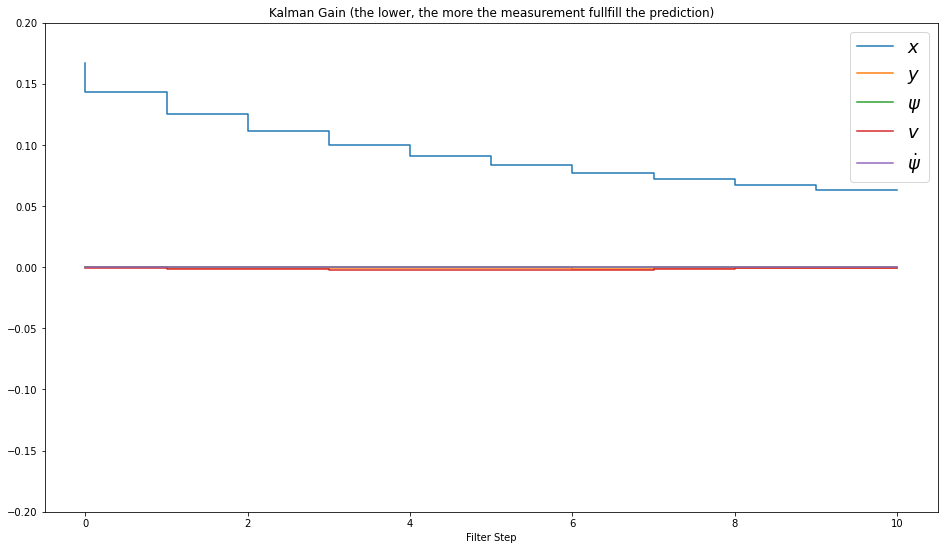

In [4]:
fig = plt.figure(figsize=(16,9))
plt.step(range(m),Kx, label='$x$')
plt.step(range(m),Ky, label='$y$')
plt.step(range(m),Kdx, label='$\psi$')
plt.step(range(m),Kdy, label='$v$')
plt.step(range(m),Kddx, label='$\dot \psi$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.2,0.2]);

### Uncertainties

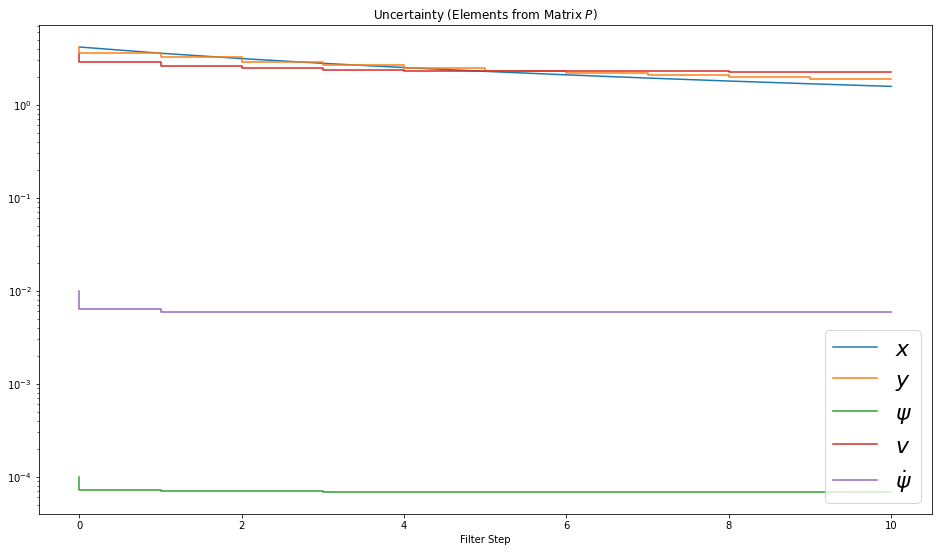

In [5]:

fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Pdx, label='$\psi$')
plt.step(range(m),Pdy, label='$v$')
plt.step(range(m),Pddx, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

### Position x/y

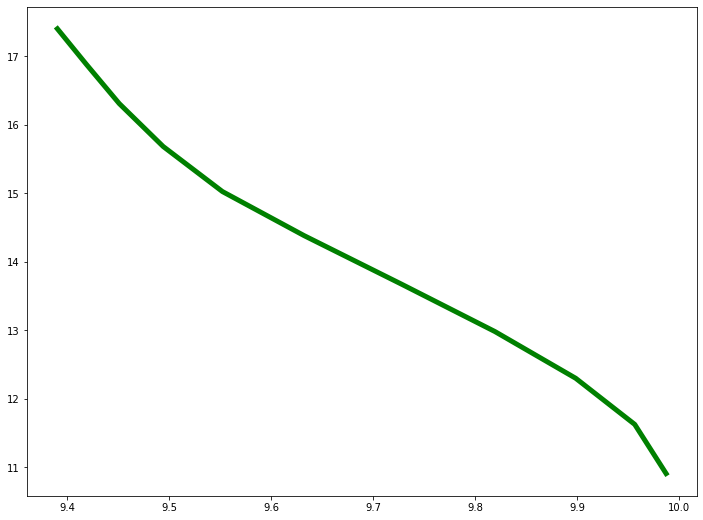

In [6]:
fig = plt.figure(figsize=(12,9))

plt.plot(x0,x1, label='EKF Position', c='g', lw=5)